#  FTL Ethiopia Project-Based Learning Labs (Lab 1 & Lab 2)
### Author: Hailom Asegede
### Date: July 2025

**Objective:** Analyze and model river plastic pollution using supervised and unsupervised ML techniques.

## Section 1: Import Libraries
_All required Python libraries are imported once here._

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve
)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import io
import requests


## Section 2: Load Dataset from Online Google Drive
_We load the dataset from the provided public Google Drive link._

In [ ]:

file_url = "https://drive.google.com/uc?id=1zIk9JOdJEu9YF7Xuv2C8f2Q8ySfG3nHd"
df = pd.read_csv(file_url)
print(" Dataset loaded successfully!")


 Dataset loaded successfully!


## Section 3: Data Cleaning and Preprocessing
_We clean the dataset, remove empty columns, handle numeric formatting, and drop NaNs._

In [ ]:

df.drop(columns=[col for col in df.columns if df[col].isnull().all()], inplace=True)

def clean_numeric(col):
    return col.str.replace("'", "", regex=False).str.replace("%", "", regex=False).astype(float)

columns_to_clean = [
    'Area [km2]', 'Coast length [km]', 'Rainfall [mm year -1]',
    'P[E] [%]', 'MPW (metric tons year -1)',
    'M[E] (metric tons year -1)', 'Ratio Me/MPW'
]

for col in columns_to_clean:
    df[col] = clean_numeric(df[col])

df.dropna(inplace=True)
df.head()


,Country or Administrative area,Area [km2],Coast length [km],Rainfall [mm year -1],Factor L/A [-],Factor (L/A) *P [-],P[E] [%],MPW (metric tons year -1),M[E] (metric tons year -1),Ratio Me/MPW
0,Albania,28486.0,362.0,1117.0,0.0100,14.0,1.56,69833.0,1565.0,2.24
1,Algeria,2316559.0,998.0,80.0,0.0004,0.0,0.09,764578.0,5774.0,0.76
2,Angola,1247357.0,1600.0,1025.0,0.0010,1.0,0.09,236946.0,860.0,0.36
3,Antigua and Barbuda,443.0,153.0,996.0,0.3000,344.0,3.08,627.0,2.0,0.29
4,Argentina,2779705.0,4989.0,567.0,0.0020,1.0,0.26,465808.0,4137.0,0.89


# LAB 1: SUPERVISED LEARNING – River Plastic Classification (Logistic Regression)

## Section 4: Define Labels and Features
_We create the target column for binary classification: high vs low plastic contribution._

In [ ]:

df['plastic_contribution'] = np.where(df['M[E] (metric tons year -1)'] > 6008, 0, 1)

features = [
    'Area [km2]', 'Coast length [km]', 'Rainfall [mm year -1]',
    'Factor L/A [-]', 'Factor (L/A) *P [-]', 'P[E] [%]',
    'MPW (metric tons year -1)', 'Ratio Me/MPW'
]

X = df[features]
y = df['plastic_contribution']


## Section 5: Scale Features and Split Dataset
_We scale features and split the dataset into training and testing sets._

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


## Section 6: Train and Evaluate Logistic Regression Model
_Train a Logistic Regression model and evaluate using accuracy, precision, recall, ROC._

In [ ]:

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")


Accuracy: 0.9394
Precision: 0.9375
Recall: 1.0000
ROC AUC: 0.8667


## Section 7: Visualize Confusion Matrix and ROC Curve
_We display classification performance visually._

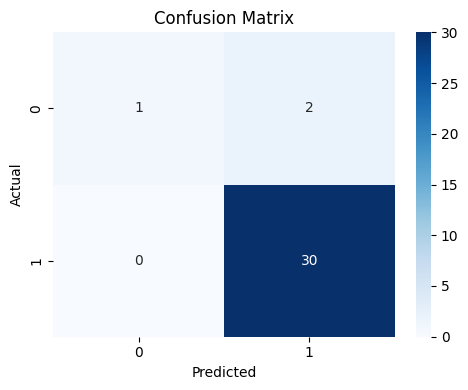

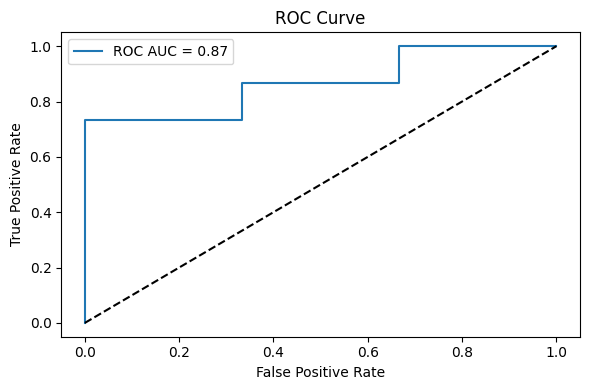

In [ ]:

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


# LAB 2: UNSUPERVISED LEARNING – River Clustering (K-Means Clustering)

## Section 8: Prepare Data for Clustering
_We reuse and scale the cleaned dataset to prepare it for clustering._

In [ ]:

features_clustering = [
    'Area [km2]', 'Coast length [km]', 'Rainfall [mm year -1]',
    'Factor L/A [-]', 'Factor (L/A) *P [-]', 'P[E] [%]',
    'MPW (metric tons year -1)', 'M[E] (metric tons year -1)',
    'Ratio Me/MPW'
]

X_cluster = df[features_clustering]
X_cluster_scaled = scaler.fit_transform(X_cluster)


##  Section 9: Apply K-Means Clustering
_We apply K-Means clustering to group rivers into 3 clusters._

In [ ]:

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

score = silhouette_score(X_cluster_scaled, df['Cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.714


##  Section 10: Visualize Clusters using PCA
_Use PCA to reduce dimensions for easy 2D visualization._

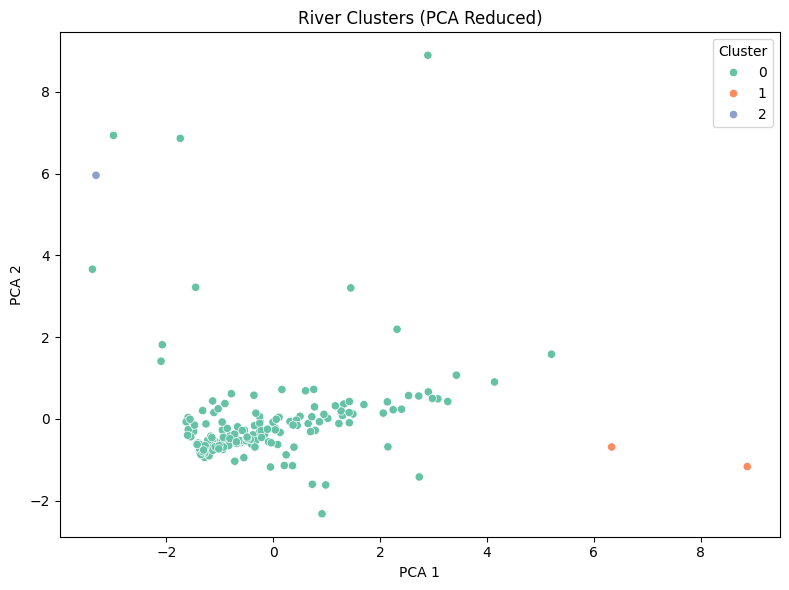

In [ ]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2')
plt.title('River Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
